In [3]:
# Cargamos datos
import Loading_data 
from matplotlib import pyplot as plt    
import warnings
warnings.filterwarnings('ignore')
import pandas as pd


In [107]:
df = pd.read_csv('https://momo.isciii.es/public/momo/data')
df.to_csv('/tmp/momo.csv')
df.head()

,ambito,cod_ambito,cod_ine_ambito,nombre_ambito,cod_sexo,nombre_sexo,cod_gedad,nombre_gedad,fecha_defuncion,defunciones_observadas,defunciones_observadas_lim_inf,defunciones_observadas_lim_sup,defunciones_esperadas,defunciones_esperadas_q01,defunciones_esperadas_q99
0,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-19,1060,1060.0,1060.0,1026.5,945.94,1135.31
1,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-20,970,970.0,970.0,1029.5,945.94,1123.58
2,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-21,1000,1000.0,1000.0,1031.0,934.90,1122.65
3,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-22,1005,1005.0,1005.0,1037.0,934.90,1136.41
4,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-23,1082,1082.0,1082.0,1031.5,928.69,1136.41


In [245]:
import janitor
import datetime



def pipeline_basic_with_query(df,query):
    """ Basic filtering, using janitor """
    LISTA_COLUMNAS_A_BORRAR = ['Unnamed: 0',
                           'defunciones_observadas_lim_inf',
                           'defunciones_observadas_lim_sup',
                           'defunciones_esperadas',
                           'defunciones_esperadas_q01',
                           'defunciones_esperadas_q99']
    return (
        df
        # Quitar: columnas
        .remove_columns(LISTA_COLUMNAS_A_BORRAR)
        .clean_names()
        # Filtrar:por query
        .filter_on( query )
        # Enriquecer: fechas con columnas de años, mes y año-mes
        .rename_column( "fecha_defuncion", "date")
        .to_datetime('date')
        .join_apply(lambda x: x['date'].strftime('%Y')    , new_column_name="date_year"       )
        .join_apply(lambda x: x['date'].strftime('%m')    , new_column_name="date_month"      )
        .join_apply(lambda x: x['date'].strftime('%U')    , new_column_name="date_week"       )
        .join_apply(lambda x: x['date'].strftime('%Y-%m') , new_column_name="date_year_month" )
        .join_apply(lambda x: x['date'].strftime('%Y-%U') , new_column_name="date_year_week"  )
        .set_index('date')
    )

def pipeline_basic(df):
    query = 'ambito       == "nacional" & nombre_gedad == "todos"  & nombre_sexo  == "todos"  '
    return pipeline_basic_with_query(df,query)

def pipeline_agregado_anual(periodo_de_tiempo,df,year):
    return (
        df
        .filter_on('date_year == "'+year+'"'  )
        .groupby_agg( by='date_'+periodo_de_tiempo, agg='sum', agg_column_name="defunciones_observadas", new_column_name="agregados")
        .rename_column( "agregados", year)
        .join_apply(lambda x: x['date_'+periodo_de_tiempo]  , new_column_name=periodo_de_tiempo )
        .set_index('date_'+periodo_de_tiempo)
        [[periodo_de_tiempo,year]]
        .drop_duplicates()        
    )

def pipeline_comparativa_anual(periodo_de_tiempo,df_2018,df_2019,df_2020):
    """ Mergea tres dataframes de año, por periodo de tiempo"""
    return  (
    df_2018
    .merge( df_2019, on=periodo_de_tiempo, how='right')
    .merge( df_2020, on=periodo_de_tiempo, how='left')
    .sort_naturally(periodo_de_tiempo)
    .set_index(periodo_de_tiempo)
    .join_apply(lambda x: x['2020'] - x['2019'] , new_column_name="resta 2020 y 2019"  )
    )

def extraer_defunciones_anuales_por_periodo(periodo_de_tiempo,query):
    """Extrae el cuadro de comparativa por week, or year """
    # Sacamos los datos y limpiamos
    df       = pd.read_csv('/tmp/momo.csv')
    df_basic = pipeline_basic_with_query(df,query)

    # Sacamos los datos agrupados por años
    muertes_2018  = pipeline_agregado_anual(periodo_de_tiempo,df=df_basic,year='2018')
    muertes_2019  = pipeline_agregado_anual(periodo_de_tiempo,df=df_basic,year='2019')
    muertes_2020  = pipeline_agregado_anual(periodo_de_tiempo,df=df_basic,year='2020')

    # Generamos un solo cuadro, con columna por año
    df_comparativa_años  = pipeline_comparativa_anual(periodo_de_tiempo,muertes_2018,muertes_2019,muertes_2020)
    return df_comparativa_años

#query = 'ambito       == "nacional" & nombre_gedad == "todos"  & nombre_sexo  == "todos"  '
#df_muertes_anuales_por_semana = extraer_defunciones_anuales_por_periodo("week",query)
#df_muertes_anuales_por_mes    = extraer_defunciones_anuales_por_periodo("month",query)


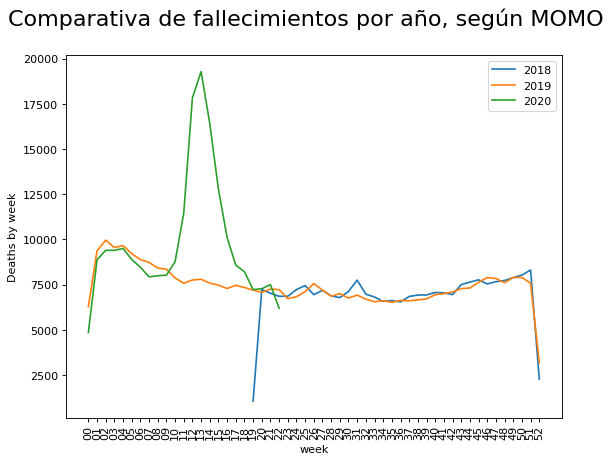

,2018,2019,2020,resta 2020 y 2019
week,,,,
00,nan,"6,282","4,849","-1,433"
01,nan,"9,368","8,874",-494
02,nan,"9,960","9,396",-564
03,nan,"9,548","9,395",-153
04,nan,"9,654","9,497",-157
05,nan,"9,209","8,891",-318
06,nan,"8,888","8,459",-429
07,nan,"8,725","7,930",-795
08,nan,"8,422","7,990",-432


In [246]:
from matplotlib import pyplot as plt    
from IPython.display import display, HTML
import pandas as pd

import numpy as np

periodo_de_tiempo="week"
query = 'ambito       == "nacional" & nombre_gedad == "todos"  & nombre_sexo  == "todos"  '

df = extraer_defunciones_anuales_por_periodo(periodo_de_tiempo,query) 

fig = plt.figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=90)

for ca in ['2018','2019','2020']:
    plt.plot(df[ca])
    plt.legend(df.columns)
    plt.xlabel(periodo_de_tiempo)
    plt.ylabel("Deaths by " + periodo_de_tiempo)
    fig.suptitle('Comparativa de fallecimientos por año, según MOMO', fontsize=20)
plt.show()


#df['resta 2020 y 2019'] = df['2020'] - df['2019']

df.style.format({"2020": "{:20,.0f}", 
                          "2018": "{:20,.0f}", 
                          "2019":  "{:20,.0f}", 
                          "resta 2020 y 2019": "{:20,.0f}", }).background_gradient(cmap='Wistia',subset=['resta 2020 y 2019'])



In [247]:
# Sacamos las muertes en madrid de hombres y de mujeres

import numpy as np 
import seaborn as sns

query = 'nombre_ambito       == "Madrid, Comunidad de" & nombre_gedad == "todos"  & nombre_sexo  == "hombres"  '
periodo_de_tiempo="week"
df_muertes_madrid_por_semana_hombres = extraer_defunciones_anuales_por_periodo(periodo_de_tiempo,query)

query = 'nombre_ambito       == "Madrid, Comunidad de" & nombre_gedad == "todos"  & nombre_sexo  == "hombres"  '
periodo_de_tiempo="week"
df_muertes_madrid_por_semana_mujeres = extraer_defunciones_anuales_por_periodo(periodo_de_tiempo,mujeres)

df_muertes_madrid_por_semana_mujeres.columns=['']

,2018,2019,2020,resta 2020 y 2019
month,,,,
01,NaN,2023,1856.0,-167.0
02,NaN,1815,1637.0,-178.0
03,NaN,1723,5805.0,4082.0
04,NaN,1576,4484.0,2908.0
05,665.0,1610,1837.0,227.0
06,1573.0,1575,286.0,-1289.0
07,1445.0,1533,NaN,NaN
08,1415.0,1382,NaN,NaN
09,1475.0,1386,NaN,NaN


In [229]:
df.info
df.describe()

,2018,2019,2020,resta 2020 y 2019
count,34.000000,53.000000,23.000000,23.000000
mean,6880.352941,7440.358491,9777.478261,1721.347826
std,1401.404531,1051.417945,3595.561037,3704.798922
min,1060.000000,3185.000000,4849.000000,-1433.000000
25%,6853.750000,6858.000000,7960.000000,-430.500000
50%,7032.000000,7286.000000,8760.000000,30.000000
75%,7526.500000,7836.000000,9800.000000,1967.500000
max,8306.000000,9960.000000,19279.000000,11484.000000


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


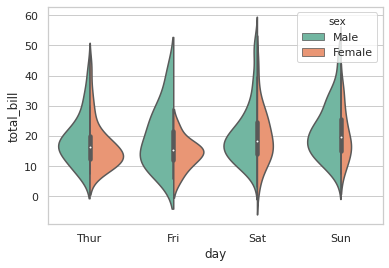

In [251]:
import seaborn as sns
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.violinplot(x="day", y="total_bill", hue="sex",
                    data=tips, palette="Set2", split=True,
                    scale="count")
tips

In [6]:
# Aux functions
def print_categorical_variables(df):
    """ Get a dict with categorical variables"""    
    my_dict = {}
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    # Show categorical values
    categorical = list(set(cols) - set(num_cols))
    for i in categorical : 
        if 'echa' not in i.lower() : my_dict[i] = df[i].unique()         
    return my_dict
df = get_momo()
my_dict = print_categorical_variables(df)
my_dict

{'cod_ambito': array([nan, 'AN', 'AR', 'AS', 'IB', 'CN', 'CB', 'CL', 'CM', 'CT', 'VC',
        'EX', 'GA', 'MD', 'MC', 'NC', 'PV', 'RI', 'CE', 'ML'], dtype=object),
 'cod_sexo': array(['all', '1', '6'], dtype=object),
 'nombre_sexo': array(['todos', 'hombres', 'mujeres'], dtype=object),
 'cod_gedad': array(['all', 'menos_65', '65_74', 'mas_74'], dtype=object),
 'nombre_ambito': array([nan, 'Andalucía', 'Aragón', 'Asturias, Principado de',
        'Balears, Illes', 'Canarias', 'Cantabria', 'Castilla y León',
        'Castilla - La Mancha', 'Cataluña', 'Comunitat Valenciana',
        'Extremadura', 'Galicia', 'Madrid, Comunidad de',
        'Murcia, Región de', 'Navarra, Comunidad Foral de', 'País Vasco',
        'Rioja, La', 'Ceuta', 'Melilla'], dtype=object),
 'nombre_gedad': array(['todos', 'edad < 65', 'edad 65-74', 'edad > 75'], dtype=object),
 'ambito': array(['nacional', 'ccaa'], dtype=object)}